### Realized Variance and Variance Swaps

#### Realized Variance
* Historical/realized variance $\sigma^2 = \frac {252}{N} \sum_{n=1}^N R_n^2$
* For time series $S_n, n = 0,1,...N$ log returns $R_n = log \frac{S_n}{S_n-1}$
* 252 is number of trading days in a year
* scale by a factor of $100^2$ to get values in percent $\sigma^2 = 10000 *\frac {252}{N} \sum_{n=1}^N R_n^2$

In [10]:
import math
import numpy as np
import pandas as pd

#### Let's get historical EuroStoxx 50 index levels

In [11]:
# ## text/csv file containing daily closing levels of EURO STOXX 50 index
path = 'https://www.stoxx.com/document/Indices/Current/HistoricalData/'
es_url = path + 'hbrbcpe.txt'

## column names for the data set
cols = ['Date', 'SX5P', 'SX5E', 'SXXP', 'SXXE',
        'SXXF', 'SXXA', 'DK5F', 'DKXF', 'DEL']
try: # reading the data with pandas
    es = pd.read_csv(es_url,  # filename
                     header=None,  # ignore column names
                     index_col=0,  # index column (dates)
                     parse_dates=True,  # parse these dates
                     dayfirst=True,  # format of dates
                     skiprows=4,  # ignore these rows
                     sep=';',  # data separator
                     names=cols)  # use these column names
    del es['DEL']
except: # read stored data if there is no Internet connection
    es = pd.HDFStore('/data/SX5E.h5', 'r')['SX5E']
    pass
es = es[es.index < '2015-12-31']

In [12]:
es.tail()

,SX5P,SX5E,SXXP,SXXE,SXXF,SXXA,DK5F,DKXF
Date,,,,,,,,
2015-12-23,3109.23,3286.68,366.39,346.14,433.58,375.53,9927.33,614.12
2015-12-24,3108.11,3284.47,366.28,346.05,433.43,375.39,9931.72,614.38
2015-12-28,3093.61,3256.49,364.49,343.54,431.26,374.32,9873.94,611.58
2015-12-29,3139.28,3314.28,369.68,349.29,438.43,378.86,10023.66,620.66
2015-12-30,3118.07,3287.98,367.70,347.02,435.82,377.20,9956.22,617.48


In [13]:
import seaborn as sns; sns.set()
import matplotlib
matplotlib.rcParams['font.family'] = 'serif'
%matplotlib inline

#### Let's plot those values

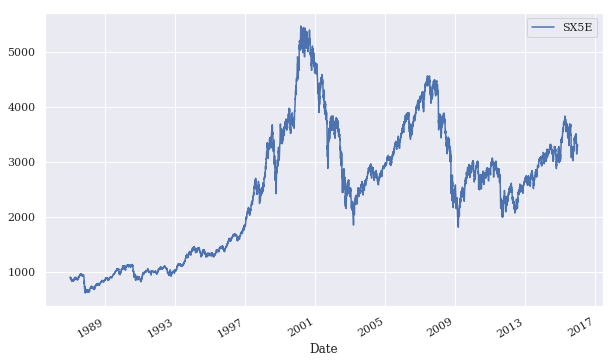

In [14]:
data = pd.DataFrame({'SX5E': es['SX5E']})
data.plot(figsize=(10, 6));

* Compute log returns
* Compute variance
* Compute payoff as difference between realized vol and strike vol

In [16]:
#log returns
data['R_n'] = np.log(data['SX5E']/data['SX5E'].shift(1))

In [17]:
data.tail()

,SX5E,R_n
Date,,
2015-12-23,3286.68,0.022262
2015-12-24,3284.47,-0.000673
2015-12-28,3256.49,-0.008555
2015-12-29,3314.28,0.017590
2015-12-30,3287.98,-0.007967


In [18]:
#variance as percentage
data['sigma**2'] = 10000 * 252 * (np.cumsum(data['R_n'] ** 2) 
                                  / np.arange(len(data)))

In [19]:
data.tail()

,SX5E,R_n,sigma**2
Date,,,
2015-12-23,3286.68,0.022262,446.280005
2015-12-24,3284.47,-0.000673,446.220423
2015-12-28,3256.49,-0.008555,446.185389
2015-12-29,3314.28,0.017590,446.230025
2015-12-30,3287.98,-0.007967,446.191722


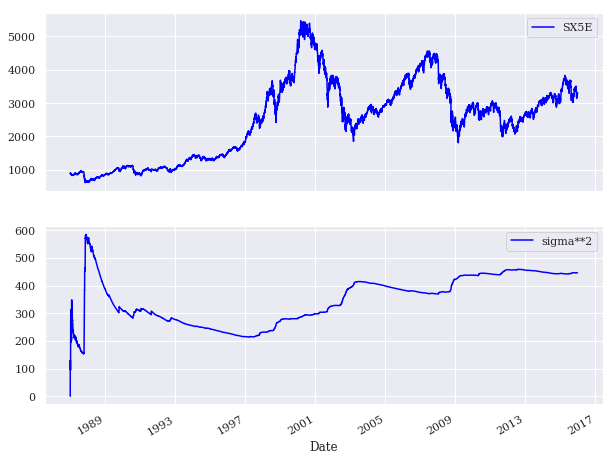

In [20]:
data[['SX5E', 'sigma**2']].plot(subplots=True,
                                 figsize=(10, 8),
                                 color='blue',
                                 grid=True);

In [21]:
## select time series data with date later/earlier than given dates
short = data[['SX5E', 'R_n']][(data.index > '2015-7-1')
                             & (data.index <= '2015-12-31')]

## calculate the realized variance in percent values
short['sigma**2'] = 10000 * 252 * (np.cumsum(short['R_n'] ** 2)
                                   / np.arange(len(short)))


In [22]:
short.tail()

,SX5E,R_n,sigma**2
Date,,,
2015-12-23,3286.68,0.022262,666.124845
2015-12-24,3284.47,-0.000673,660.804967
2015-12-28,3256.49,-0.008555,657.024371
2015-12-29,3314.28,0.017590,657.990720
2015-12-30,3287.98,-0.007967,654.099798


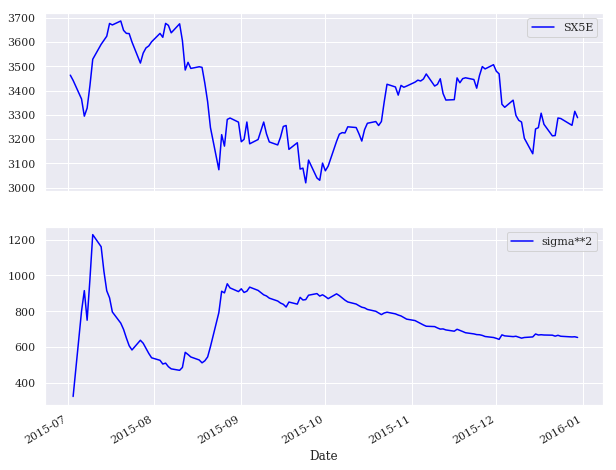

In [23]:
short[['SX5E', 'sigma**2']].plot(subplots=True,
                                 figsize=(10, 8),
                                 color='blue',
                                 grid=True);

In [24]:
import sys
sys.path.append('scripts/')
from variance_swaps import generate_path 

In [25]:
S0 = 100  # initial index level
r = 0.005  # risk-less short rate
sigma = 0.2  # instantaneous volatility
T = 1.0 # maturity date
M = 50  # number of time intervals

* Generate synthetic index levels based on brownian motion SDE

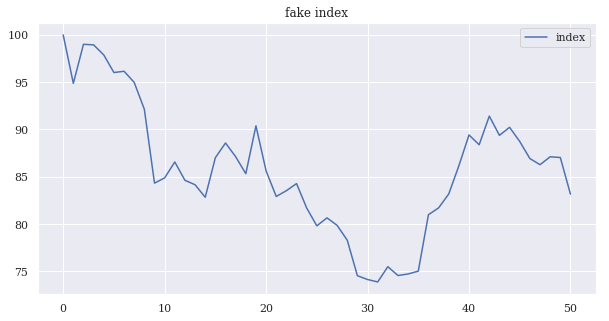

In [28]:
data = generate_path(S0, r, sigma, T, M)
data.plot(figsize=(10, 5), title='fake index');

In [29]:
data['R_t'] = np.log(data['index'] / data['index'].shift(1))
## scaling now by M / T since returns are not necessarily daily returns
data['sigma**2'] = 10000 * M / T * (np.cumsum(data['R_t'] ** 2)
                                    / np.arange(len(data)))
data.tail()

,index,R_t,sigma**2
46,86.914274,-0.020492,462.916655
47,86.263467,-0.007516,453.668339
48,87.101314,0.009666,445.190118
49,87.020414,-0.000929,436.113416
50,83.157399,-0.045408,448.009603


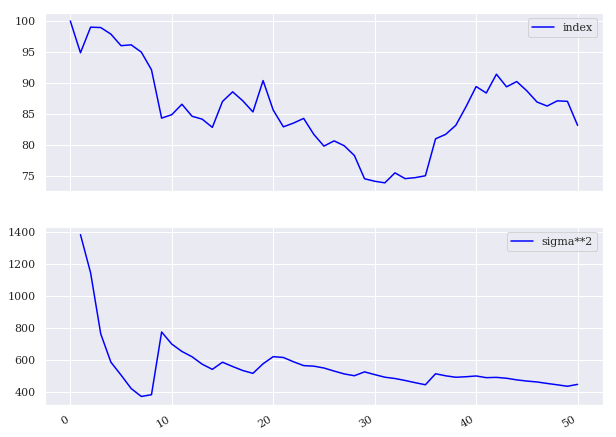

In [30]:
data[['index', 'sigma**2']].plot(subplots=True,
                                 figsize=(10, 8),
                                 color='blue',
                                 grid=True);

In [31]:
#compute payoff 
data['sigma**2'].iloc[-1] - 20 ** 2

48.009603247833468

#### Notional

* Variance swaps have a notional value not equal to 1
* To calculate the payoff you need to multiply the notional by the payoff $h_t$
* $Notional = \frac {VegaNotional}{2 * strike}$
* VegaNotional currency units for every 1 percent shift in realized volatility above strike

In [32]:
Notional = 100000. / (2 * 20)
Notional

2500.0

In [33]:
Notional * (data['sigma**2'].iloc[-1] - 20 ** 2)

120024.00811958367

#### Mark-to-Market

* What is behavior of variance swap over time
* Variance swap is additive
* $V_t = Notional * e^{-r(T-t)} * (\frac {t * \sigma_{0,t}^2 + (T-t) * \sigma_{i}^2(t,T)}{T} - \sigma_{K}^2)$

* major component of mark-to-market value of variance swap is time weighted average of realized variance and time wieghted implied variance
* $\sigma_{0,t}^2$: time weighted average of realized variance up to time $t$
* $\sigma_{i}^2(t,T)$ time weighted average implied variance from $t$ to $T$

In [36]:
dt = T / M
t = np.arange(M + 1) * dt
t
sigma_K = 20
data['V_t'] = Notional * np.exp(-r * (T - t)) * ((t * data['sigma**2']
                        + (T - t) * sigma_K ** 2) / T - sigma_K ** 2) 
data.tail()

,index,R_t,sigma**2,V_t
46,86.914274,-0.020492,462.916655,144650.434548
47,86.263467,-0.007516,453.668339,126082.766551
48,87.101314,0.009666,445.190118,108434.594165
49,87.020414,-0.000929,436.113416,88469.022898
50,83.157399,-0.045408,448.009603,120024.008120


* Plot below is index level, realized variance, and mark to market value of variance swap

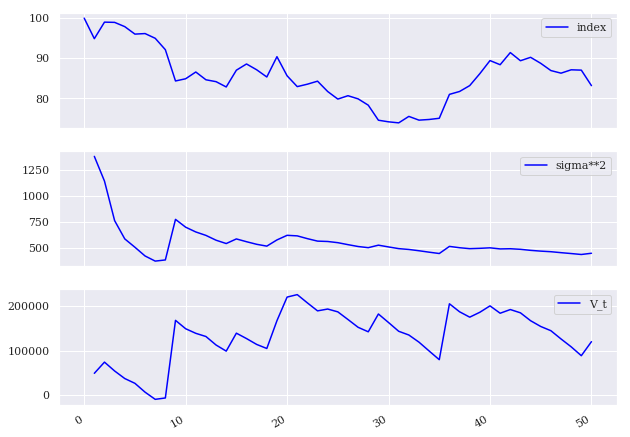

In [40]:
data[['index', 'sigma**2', 'V_t']].plot(subplots=True,
                                 figsize=(10, 8),
                                 color='blue',
                                 grid=True);

#### Vega Sensitivity

* How does implied volatility affect the market to market value of variance swap
* At inception of the Variance Swap, taking the derivative with respect to $V_0$ we have $V_0 = e^{-rT} * VegaNotional $
* So at inception Vega is equal to discounted Vega Notional
* Taking the derivative with respect to $V_t = e^{-rT} * VegaNotional * \frac{T-t}{T}$
* So Vega sensitivity diminishes over time and is proportional to time to maturity


### Variance Swaps on EuroStoxx50

In [41]:
es.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7475 entries, 1986-12-31 to 2015-12-30
Data columns (total 9 columns):
SX5P    7475 non-null float64
SX5E    7475 non-null float64
SXXP    7475 non-null float64
SXXE    7475 non-null float64
SXXF    7475 non-null float64
SXXA    7475 non-null float64
DK5F    7475 non-null float64
DKXF    7475 non-null float64
R_n     7474 non-null float64
dtypes: float64(9)
memory usage: 584.0 KB


In [42]:
vs_url = path + 'h_vstoxx.txt'
try: # reading the data with pandas
    vs = pd.read_csv(vs_url,  # filename
                     index_col=0,  # index column (dates)
                     parse_dates=True,  # parse date information
                     dayfirst=True, # day before month
                     header=2,  # header/column names
                     sep=',')  # separator character
except: # read stored data if there is no Internet connection
    vs = pd.HDFStore('./source/data/V2TX.h5', 'r')
vs.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4357 entries, 1999-01-04 to 2016-02-12
Data columns (total 9 columns):
V2TX    4357 non-null float64
V6I1    3906 non-null float64
V6I2    4357 non-null float64
V6I3    4296 non-null float64
V6I4    4357 non-null float64
V6I5    4357 non-null float64
V6I6    4340 non-null float64
V6I7    4357 non-null float64
V6I8    4343 non-null float64
dtypes: float64(9)
memory usage: 340.4 KB


* V6I2 represents implied volatility for the nearest optoin series maturity date
* So for June 1, the V6I2 is for the maturity date on the third Friday of June.
* In this case the 3rd Friday of June is in 15 days


In [43]:
T = 15
vega_notional = 100000
data = pd.DataFrame(es['SX5E'][(es.index > '2015-5-31')
                        & (es.index < '2015-6-20')])

In [44]:
data['V6I1'] = vs['V6I1'][(vs.index > '2015-5-31')
                        & (vs.index < '2015-6-20')]

In [45]:
data.head()

,SX5E,V6I1
Date,,
2015-06-01,3575.04,25.8710
2015-06-02,3561.89,25.9232
2015-06-03,3583.82,25.7958
2015-06-04,3556.38,26.2418
2015-06-05,3510.01,27.4496


In [46]:
data = data.fillna(method='ffill')

In [47]:
data['V6I1'][0]
sigma_K = data['V6I1'][0]
Notional = 100000 / (2. * sigma_K)
Notional

1932.665919369178

* Compute log returns of index
* Realized Variance of index 
* Mark-to-market variance swap values


In [49]:
data['R_t'] = np.log(data['SX5E']/data['SX5E'].shift(1))

In [52]:
data['sigma**2'] = 10000 * 252 * (np.cumsum(data['R_t']**2)/len(data))

In [53]:
data.head()

,SX5E,V6I1,R_n,R_t,sigma**2
Date,,,,,
2015-06-01,3575.04,25.8710,NaN,NaN,NaN
2015-06-02,3561.89,25.9232,-0.003685,-0.003685,2.281387
2015-06-03,3583.82,25.7958,0.006138,0.006138,8.610728
2015-06-04,3556.38,26.2418,-0.007686,-0.007686,18.535510
2015-06-05,3510.01,27.4496,-0.013124,-0.013124,47.472992


In [58]:
#num days
t = np.arange(1,16)
# assumed fixed short rate
r = 0.001

In [59]:
data['V_t'] = np.exp(-r * (T - t) / 365.) * ((t * data['sigma**2']
                + (T - t) * data['V6I1'] ** 2) / T - sigma_K ** 2)

In [60]:
data['V_t'].loc['2015-06-01'] = 0.0

In [62]:
data.head()

,SX5E,V6I1,R_n,R_t,sigma**2,V_t
Date,,,,,,
2015-06-01,3575.04,25.8710,NaN,NaN,NaN,0.000000
2015-06-02,3561.89,25.9232,-0.003685,-0.003685,2.281387,-86.590714
2015-06-03,3583.82,25.7958,0.006138,0.006138,8.610728,-135.243411
2015-06-04,3556.38,26.2418,-0.007686,-0.007686,18.535510,-159.364186
2015-06-05,3510.01,27.4496,-0.013124,-0.013124,47.472992,-151.159809


In [63]:
Notional * data['V_t'][-1]

-791539.49295440421

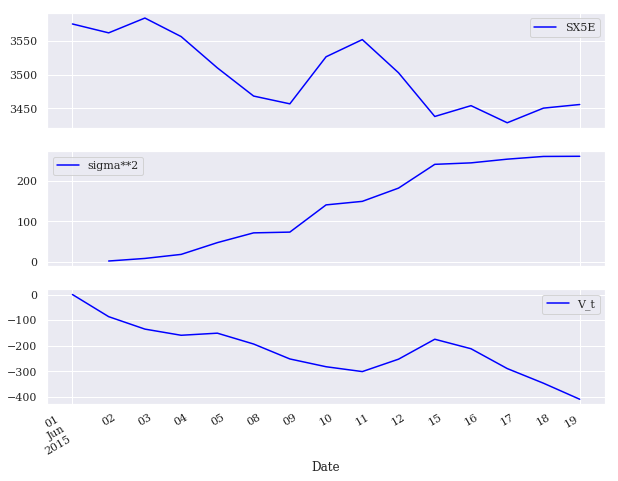

In [64]:
data[['SX5E', 'sigma**2', 'V_t']].plot(subplots=True,
                                       color='blue',
                                       figsize=(10, 8));

#### Variance vs Volatility

* Squared variations ensures that variations through time are not canceled out
* Volatility ensures this because it is the square root, Variance does this by squaring
* Additivity in time: Variance is (additive) linear and volatility is convex (nonlinear) 
* $\sqrt{a + b} \leq \sqrt{a} + \sqrt{b}$


#### Static Hedges

* realized vol can be statically replicated with out of the money put and call options
* You can statically replicate and hedge variance swaps with the use of options, which is not available with vol swaps


#### Risk measure

* Implied vol is only for a given instrument in a given maturity at a certain strike
* When spot moves at the money implied vol changes 
* Implied variance takes into account all strikes at a given maturity 
* The traded variance level of a variance swap is applicable independently of the spot of underlying
